In [1]:
import csv # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline

# Perform exploratory data analysis to validate the intuitive assumption that rating, verified purchase and product category are the 3 most relevant additional features to include in the model as to improve it

In [2]:
# Import specific python packages for dataframe manipulation, plotting and visualisation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read TXT as a CSV file with delimiters

data = pd.read_csv("amazon_reviews.txt", delimiter = "\t")
data.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [4]:
# Convert both categorical labels to meaningful numeric values

data.loc[data["LABEL"] == "__label1__", "LABEL"] = '1'
data.loc[data["LABEL"] == "__label2__", "LABEL"] = '0'

In [5]:
# Group by label and count values in the 'Rating' column

labelsGrouped = data.groupby(data["LABEL"]).RATING.value_counts()

labelsGrouped

LABEL  RATING
0      5         6151
       4         1974
       3          942
       1          868
       2          565
1      5         6059
       4         1999
       3          926
       1          889
       2          627
Name: RATING, dtype: int64

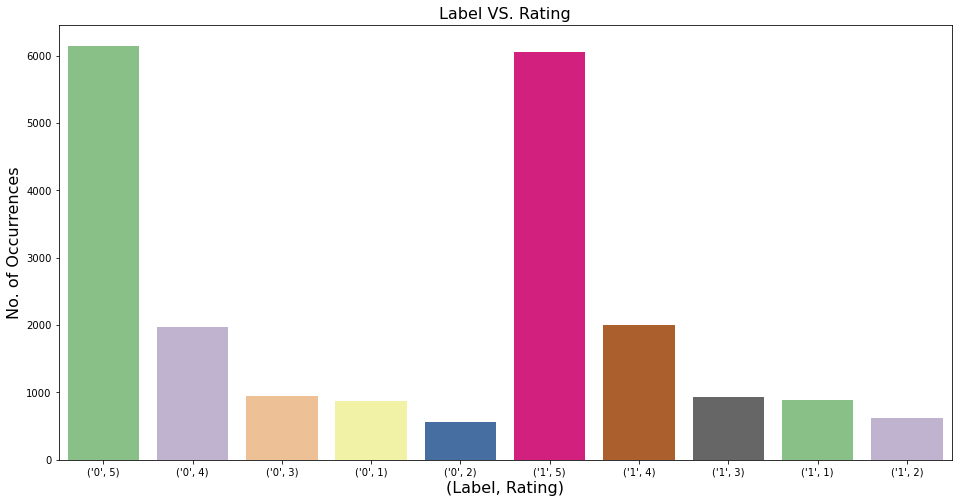

In [6]:
# Plot using a barplot (seaborn) the 'Label' vs. the 'Rating' variable

plt.figure(figsize=(16,8))

sns.barplot(labelsGrouped.index, labelsGrouped.values, palette='Accent')

plt.title('Label VS. Rating', fontsize = 16)
plt.xlabel('(Label, Rating)', fontsize = 16)
plt.ylabel('No. of Occurrences', fontsize = 16)

plt.show()

# By visually analysing the above chart, it is clear that regardless of the review label the reviews with the maximum rating (5) are the most numerous

In [7]:
# Group by the verified purchase status and count values in the 'Label' column

verifiedPurchase_grouped = data.groupby("VERIFIED_PURCHASE").LABEL.value_counts()

verifiedPurchase_grouped

VERIFIED_PURCHASE  LABEL
N                  1        7623
                   0        1679
Y                  0        8821
                   1        2877
Name: LABEL, dtype: int64

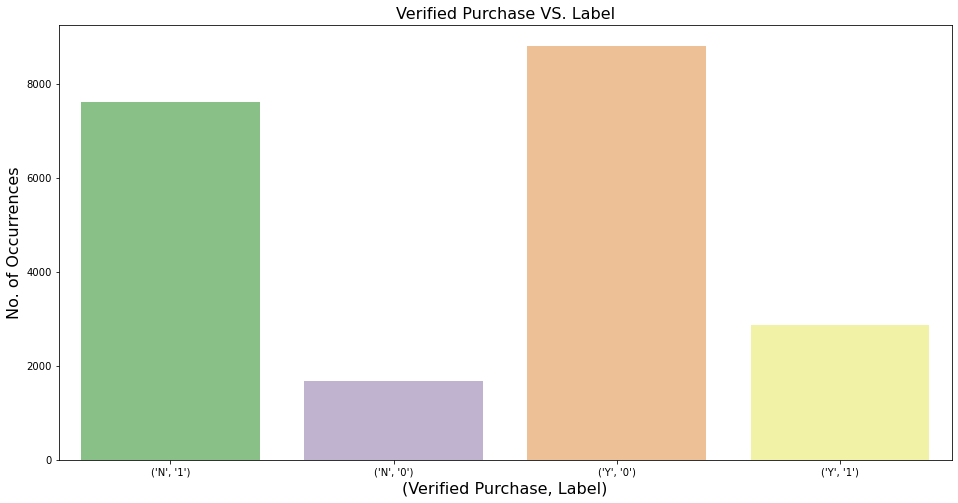

In [8]:
# Plot using a barplot (seaborn) the 'Verified Purchase' vs. the 'Label' variable

plt.figure(figsize=(16,8))

sns.barplot(verifiedPurchase_grouped.index, verifiedPurchase_grouped.values, palette = 'Accent')

plt.title('Verified Purchase VS. Label', fontsize = 16)
plt.xlabel('(Verified Purchase, Label)', fontsize = 16)
plt.ylabel('No. of Occurrences', fontsize = 16)

plt.show()

## By visually analysing the above chart, it is clear that true reviews with a verified purchase, along with fake reviews with no verified purchase are the two most prevalent categories by far in this dataset.

## Therefore, two intuitive conclusions can be drawn: 

    a) reviews with verified purchase - high probability of being true
    b) reviews with no verified purchase - high probability of being false

In [9]:
# Group by label and count values in the 'Product Category' column

labelsGrouped2 = data.groupby("LABEL").PRODUCT_CATEGORY.value_counts()

labelsGrouped2

LABEL  PRODUCT_CATEGORY      
0      Apparel                   350
       Automotive                350
       Baby                      350
       Beauty                    350
       Books                     350
       Camera                    350
       Electronics               350
       Furniture                 350
       Grocery                   350
       Health & Personal Care    350
       Home                      350
       Home Entertainment        350
       Home Improvement          350
       Jewelry                   350
       Kitchen                   350
       Lawn and Garden           350
       Luggage                   350
       Musical Instruments       350
       Office Products           350
       Outdoors                  350
       PC                        350
       Pet Products              350
       Shoes                     350
       Sports                    350
       Tools                     350
       Toys                      350
       V

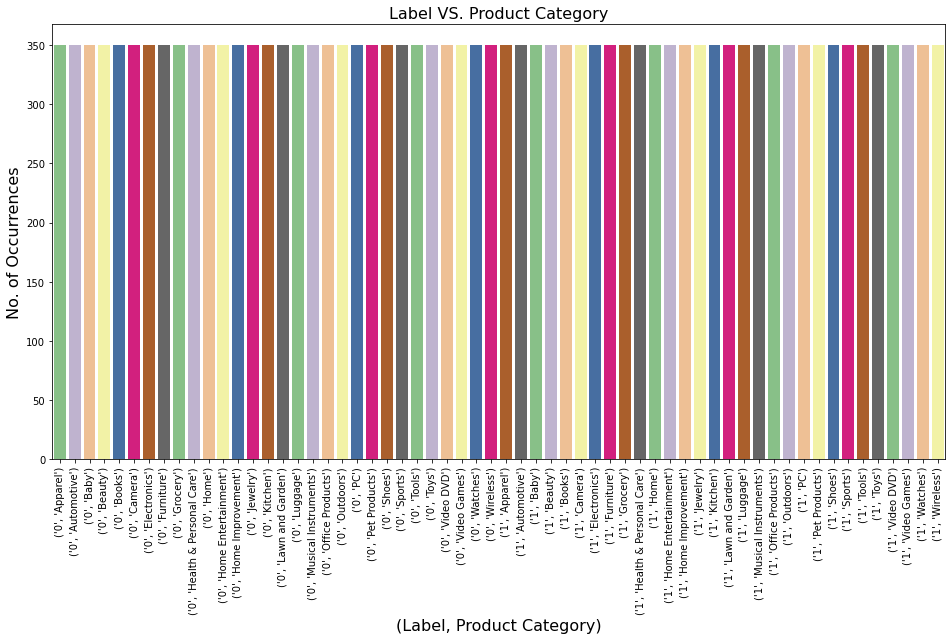

In [10]:
# Plot using a barplot (seaborn) the 'Label' vs. the 'Verified Purchase' variable

plt.figure(figsize=(16,8))

sns.barplot(labelsGrouped2.index, labelsGrouped2.values, palette = 'Accent')

plt.title('Label VS. Product Category', fontsize = 16)
plt.xlabel('(Label, Product Category)', fontsize = 16)
plt.ylabel('No. of Occurrences', fontsize = 16)

plt.xticks(rotation = 'vertical')

plt.show()

## By visually analysing the above chart, no intuitive conclusion can be drawn as this dataset is perfectly balanced in regard to the ratio of product categories corresponding to the reviews 

In [11]:
# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "DOC_ID":  # skip the header
                continue
            (Id, Rating, verifiedPurchase, productCategory, Text, Label) = parseReview(line)
            rawData.append((Id, Rating, verifiedPurchase, productCategory, Text, Label))
            
def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(rawData)
    halfOfData = int(len(rawData)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    
    for (_, Rating, verifiedPurchase, productCategory, Text, Label) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData + trainingSamples]:
        trainData.append((toFeatureVector(Rating, verifiedPurchase, productCategory, preProcess(Text)), Label))
    
    for (_, Rating, verifiedPurchase, productCategory, Text, Label) in rawData[trainingSamples:halfOfData] + rawData[halfOfData + trainingSamples:]:
        testData.append((toFeatureVector(Rating, verifiedPurchase, productCategory, preProcess(Text)), Label))

In [12]:
# Convert line from input file into an id/text/label tuple
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    # DESCRIBE YOUR METHOD IN WORDS
    
    # Initiates an empty label string, assigns it based on a conditional
    # from the second string present in a specific review line, thus
    # attributing meaningful names to the two (category) labels.
    
    # Finally assigns review ID, rating, status of verified purchase,
    # product category and review text to variables and outputs
    # a tuple containing all these features.
    
    labelString = ""
    
    if reviewLine[1] == "__label1__":
        labelString = "fake"
    else:
        labelString = "real"
    
    Id = int(reviewLine[0])
    Rating = int(reviewLine[2])
    verifiedPurchase = reviewLine[3]
    productCategory = reviewLine[4]
    Text = reviewLine[8]
    
    return (Id, Rating, verifiedPurchase, productCategory, Text, labelString)

In [13]:
# TEXT PREPROCESSING AND FEATURE VECTORIZATION

import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Input: a string of one review
def preProcess(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    
    # Instantiate specific utlity NLTK classes to call their methods on 
    # a review text string in order to preprocess it using the following
    # techniques sequentially: whitespace tokenization, stopwords removal,
    # lemmatization, along with the use of both unigrams and bigrams in
    # a concatenated list.
    
    # Finally outputs a list of tokens.
    
    # Whitespace tokenization
    tk = WhitespaceTokenizer()
    tokens = tk.tokenize(text) 
    
    # Stopwords removal
    tokens = [word for word in tokens if not word in stopwords.words("english")]
    
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Create 2 empty lists for lemmatized and for filtered (output) tokens
    lemmatizedTokens = []
    filteredTokens = []
    
    # Loop through the list containing the tokens
    for word in tokens:
        
        # Lemmatize each lowered word (token) then append it to the list
        lemmatizedTokens.append(lemmatizer.lemmatize(word.lower()))
        
        # Perform list concatenation - unigrams and bigrams
        filteredTokens = [' '.join(lem) for lem in nltk.bigrams(lemmatizedTokens)] + lemmatizedTokens
        
    return filteredTokens

In [14]:
featureDict = {} # A global dictionary of features

def toFeatureVector(Rating, verifiedPurchase, productCategory, tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    
    localDict = {}
    
    # Rating
    localDict['Rating'] = Rating
    featureDict['Rating'] = 1
    
    # Verified Purchase
    if verifiedPurchase == 'N':
        localDict['VerifiedPurchase'] = 0
    else:
        localDict['VerifiedPurchase'] = 1
        
    featureDict['VerifiedPurchase'] = 1
        
    # Product Category
    if productCategory not in localDict.keys():
        localDict[productCategory] = 1
    else:
        localDict[productCategory] += 1
        
    if productCategory not in featureDict.keys():
        featureDict[productCategory] = 1
    else:
        featureDict[productCategory] += 1
    
    # Review Text
    for word in tokens:
        if word not in localDict.keys():
            localDict[word] = 1
        else:
            localDict[word] += 1
            
        if word not in featureDict.keys():
            featureDict[word] = 1
        else:
            featureDict[word] += 1
    
    return localDict

In [15]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def trainClassifier(trainData):
    print("Training Classifier...")
    
    # Assign a regularization parameter of 0.01 (default = 1.0)
    pipeline =  Pipeline([('svc', LinearSVC(C = 0.01))])
    
    return SklearnClassifier(pipeline).train(trainData)

In [16]:
import numpy as np

def crossValidate(dataset, folds):
    shuffle(dataset)
    cv_results = []
    foldSize = int(len(dataset)/folds)
    # DESCRIBE YOUR METHOD IN WORDS
    
    # Initiates two lists for train and test data which will have elements 
    # appended to them iteratively based on the value of the variable'i' 
    # which represents the dataset index in a given iteration.
    
    # Trains the classifier, assigns to variables the ground-truth labels and 
    # classifies the test data to get the predicted labels.
    
    # Computes the weighted averages of the requested evaluation metrics 
    # (Precision, Recall, F1 Score, Accuracy) using utlity functions 
    # imported from sklearn.
    
    # Finally logs to the screen the evaluation metrics computed for each 
    # specific fold and then prints a list containing the means of all those metrics
    # as requested.
    
    iterations = -1
    
    for i in range(0,len(dataset),foldSize):
        iterations += 1
        
        trainData = dataset[i:(i+foldSize-1)]
        
        if not i:
            testData = dataset[(i+foldSize):(len(dataset)-1)]
        elif i == len(dataset)-foldSize:
            testData = dataset[0:iterations*foldSize-1]
        else:
            testData = dataset[0:iterations*foldSize-1]+dataset[(i+foldSize):(len(dataset)-1)]
        
        classifier = trainClassifier(trainData)  # train the classifier
        
        testTrue = [t[1] for t in testData]   # get the ground-truth labels from the data
        testPred = predictLabels(testData, classifier)  # classify the test data to get predicted labels
        
        # Evaluation metrics (weighted averages):
        
        # Precision and Recall
        prec_rec_f = precision_recall_fscore_support(testTrue, testPred, average='weighted')
        
        # Accuracy (normalised by default)
        accuracy = accuracy_score(testTrue, testPred)
        
        print(F"For fold number {iterations + 1} - Precision: {prec_rec_f[0]}; Recall: {prec_rec_f[1]}")
        print(F"F1 Score: {prec_rec_f[2]}; Accuracy: {accuracy}\n")
        
        cv_results.append((prec_rec_f[0], prec_rec_f[1], prec_rec_f[2], accuracy))
    
    cv_results = (np.mean(np.array(cv_results), axis=0))
    print("The mean (average) of cross-validation metrics are as follows (Precision, Recall, F1 Score, Accuracy):")
    print(cv_results)
    
    return cv_results

In [17]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [18]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
trainData = []        # the pre-processed training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the pre-processed test data as a percentage of the total dataset (currently 20%, or 4200 samples)

preprocessedData = [] # the pre-processed reviews

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing the dataset...",sep='\n')
loadData(reviewPath) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)
# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')

# QUESTION 3 - Make sure there is a function call here to the
# crossValidate function on the training set to get your results

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

crossValidate(trainData, 10)

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 21000 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
16800
Features: 
620324
Training Classifier...
For fold number 1 - Precision: 0.7979624163195538; Recall: 0.7942324227792843
F1 Score: 0.7936280467441809; Accuracy: 0.7942324227792843

Training Classifier...
For fold number 2 - Precision: 0.7914386611142862; Recall: 0.7893239846540547
F1 Score: 0.7889903384316311; Accuracy: 0.7893239846540547

Training Classifier...
For fold number 3 - Precision: 0.7946811863658666; Recall: 0.793028178330467
F1 Score: 0.7927179597584697; Accuracy: 0.793028178330467

Training Classifier...
For fold number 4 - Precision: 0.7912588115806739; Recall: 0.7881994972880011
F1 Score: 0.7876457672626163; Accuracy: 0.7881994972880011

Training Classifier...
For fold number 5 - Precision: 0.7931740094580906; Recall: 0.7901838867575076
F1 Score: 0.

array([0.79384354, 0.79154923, 0.79114605, 0.79154923])

# Evaluate on test set

In [19]:
# Finally, check the accuracy of your classifier by training on all the tranin data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(testData[0])   # have a look at the first test data instance
    classifier = trainClassifier(trainData)  # train the classifier
    testTrue = [t[1] for t in testData]   # get the ground-truth labels from the data
    testPred = predictLabels(testData, classifier)  # classify the test data to get predicted labels
    finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score: %f" % finalScores[:3])

({'Rating': 5, 'VerifiedPurchase': 0, 'Grocery': 1, 'this assortment': 1, 'assortment really': 1, "really hershey's": 1, "hershey's best.": 1, 'best. the': 1, 'the little': 1, 'little one': 1, 'one always': 1, 'always excited': 1, 'excited whenever': 1, 'whenever holiday': 1, 'holiday come': 1, 'come this.': 1, 'this': 1, 'assortment': 1, 'really': 1, "hershey's": 1, 'best.': 1, 'the': 1, 'little': 1, 'one': 1, 'always': 1, 'excited': 1, 'whenever': 1, 'holiday': 1, 'come': 1, 'this.': 1}, 'fake')
Training Classifier...
Done training!
Precision: 0.810979
Recall: 0.805952
F Score: 0.805165
